# Classifying Quickdraw Figures using CNN

In [1]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Load the data

In [2]:
flamingo = np.load('flamingo.npy')
fish = np.load('fish.npy')
bear = np.load('bear.npy')
butterfly = np.load('butterfly.npy')
apple = np.load('apple.npy')
airplane = np.load('airplane.npy')

## Assign labels to the data

In [3]:
# add a column with labels, 0=flamingo, 1=fish
flamingo = np.c_[flamingo, np.zeros(len(flamingo))]
fish = np.c_[fish, np.ones(len(fish))]
bear = np.c_[bear, 2*np.ones(len(bear))]
butterfly = np.c_[butterfly, 3*np.ones(len(butterfly))]
apple = np.c_[apple, 4*np.ones(len(apple))]
airplane = np.c_[airplane, 5*np.ones(len(airplane))]

# store the label codes in a dictionary
label_dict = {0:'flamingo', 1:'fish', 2:'bear', 3:'butterfly', 4:'apple', 5:'airplane'}

print(flamingo.shape)
print(fish.shape)
print(bear.shape)
print(butterfly.shape)
print(apple.shape)
print(airplane.shape)

(124569, 785)
(134150, 785)
(134762, 785)
(117999, 785)
(144722, 785)
(151623, 785)


## Visualize the data

In [4]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

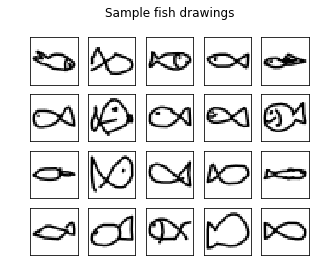

In [5]:
plot_samples(fish, title='Sample fish drawings\n')

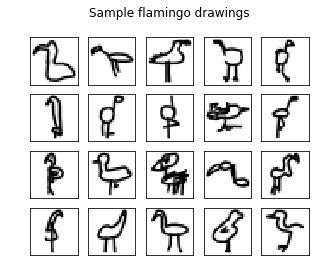

In [6]:
plot_samples(flamingo, title='Sample flamingo drawings\n')

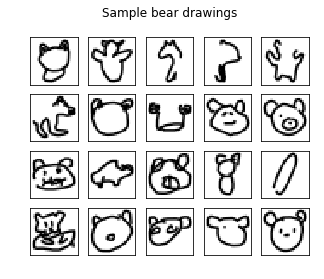

In [7]:
plot_samples(bear, title='Sample bear drawings\n')

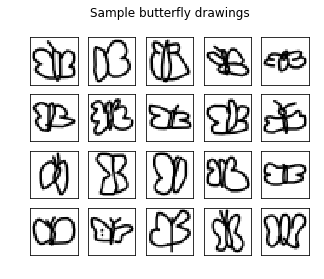

In [8]:
plot_samples(butterfly, title='Sample butterfly drawings\n')

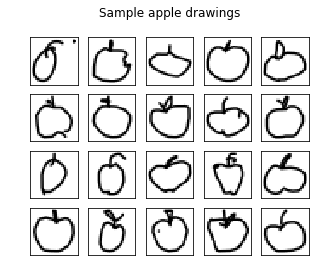

In [9]:
plot_samples(apple, title='Sample apple drawings\n')

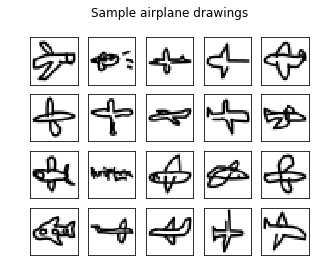

In [10]:
plot_samples(airplane, title='Sample airplane drawings\n')

## Split training set and test set

In [11]:
from sklearn.model_selection import train_test_split

# merge the flamingo and fish arrays, and split the features (X) and labels (y). Convert to float32 to save some memory.
X = np.concatenate((flamingo[:5000,:-1], fish[:5000,:-1], bear[:5000,:-1], butterfly[:5000,:-1], apple[:5000,:-1], airplane[:5000,:-1]), axis=0).astype('float32') # all columns but the last
y = np.concatenate((flamingo[:5000,-1], fish[:5000,-1], bear[:5000,-1], butterfly[:5000,-1], apple[:5000,-1], airplane[:5000,-1]), axis=0).astype('float32') # the last column

# train/test split (divide by 255 to obtain normalized values between 0 and 1)
# I will use a 50:50 split, since I want to start by training the models on 5'000 samples and thus have plenty of samples to spare for testing.
X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)

In [12]:
from keras.utils import np_utils
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

In [13]:
# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

## Build CNN Model

In [14]:
# define the CNN model
def cnn_model():
    # create model
    model = Sequential()
    
    model.add(Conv2D(32, (3, 3), padding='same', input_shape = (28, 28, 1), activation = 'relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) # antes era 0.25

    # Adding a second convolutional layer
    model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) # antes era 0.25

    # Adding a third convolutional layer
    model.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5)) # antes era 0.25

    # Step 3 - Flattening
    model.add(Flatten())

    # Step 4 - Full connection
    model.add(Dense(units = 512, activation = 'relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(units = 6, activation = 'softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Train

In [15]:
%%time

np.random.seed(0)
# build the model
model_cnn = cnn_model()
# Fit the model
model_cnn.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=10)
# Final evaluation of the model
scores = model_cnn.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN accuracy: ', scores[1])

Train on 15000 samples, validate on 15000 samples
Epoch 1/10
15000/15000 [==============================] - 74s 5ms/step - loss: 0.9451 - acc: 0.6545 - val_loss: 0.4327 - val_acc: 0.8597
Epoch 2/10
15000/15000 [==============================] - 73s 5ms/step - loss: 0.5375 - acc: 0.8287 - val_loss: 0.3427 - val_acc: 0.8897
Epoch 3/10
15000/15000 [==============================] - 68s 5ms/step - loss: 0.4494 - acc: 0.8571 - val_loss: 0.3435 - val_acc: 0.8896
Epoch 4/10
15000/15000 [==============================] - 66s 4ms/step - loss: 0.4048 - acc: 0.8717 - val_loss: 0.2743 - val_acc: 0.9109
Epoch 5/10
15000/15000 [==============================] - 66s 4ms/step - loss: 0.3847 - acc: 0.8791 - val_loss: 0.2984 - val_acc: 0.9028
Epoch 6/10
15000/15000 [==============================] - 66s 4ms/step - loss: 0.3567 - acc: 0.8855 - val_loss: 0.2718 - val_acc: 0.9193
Epoch 7/10
15000/15000 [==============================] - 68s 5ms/step - loss: 0.3522 - acc: 0.8907 - val_loss: 0.2670 - val_acc

In [16]:
model_cnn.save('flamingo_cnn.h5')

## Analyze the training and the important features

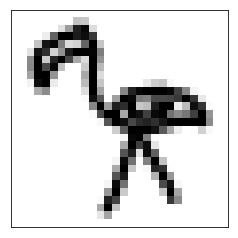

In [17]:
imgplot = plt.imshow(X_test_cnn[6].reshape(28,28), cmap='gray_r', interpolation='nearest')
plt.xticks([])
plt.yticks([])
plt.show()

In [18]:
predict = model_cnn.predict(X_test_cnn[6].reshape(1,28,28,1))
np.argmax(predict)

0

In [19]:
from keras import models
layer_outputs = [layer.output for layer in model_cnn.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model_cnn.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [20]:
activations = activation_model.predict(X_test_cnn[6].reshape(1,28,28,1)) # Returns a list of five Numpy arrays: one array per layer activation

In [21]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 32)


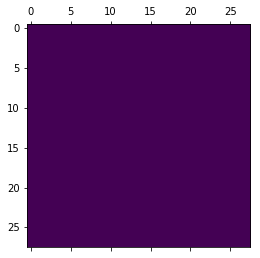

In [22]:
plt.matshow(first_layer_activation[0, :, :, 11], cmap='viridis')

c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


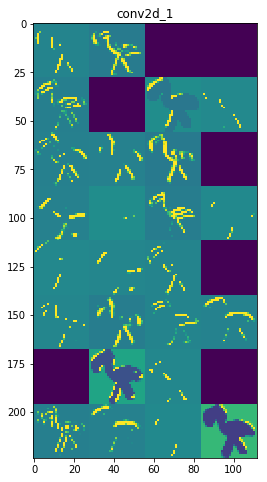

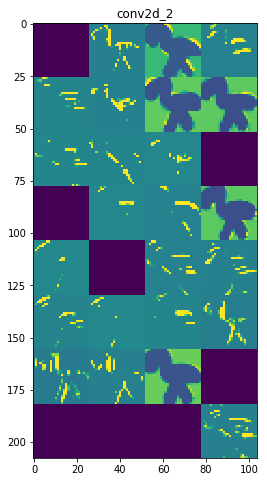

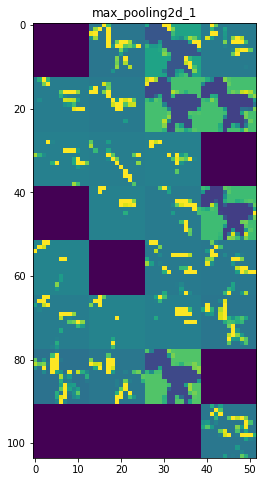

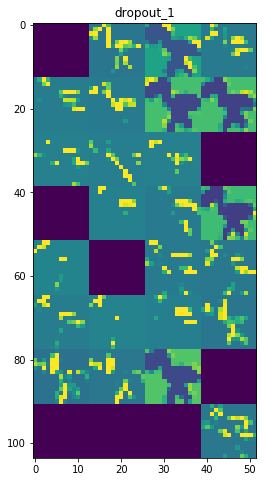

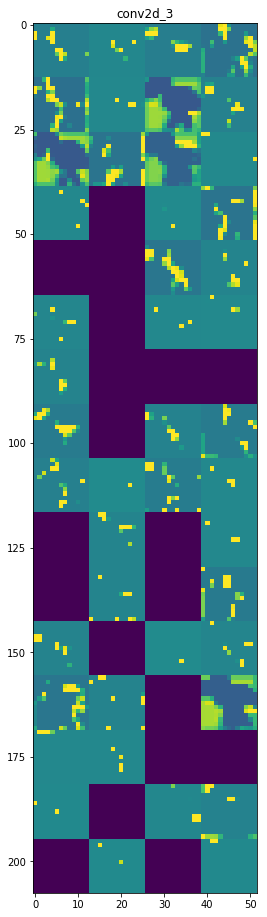

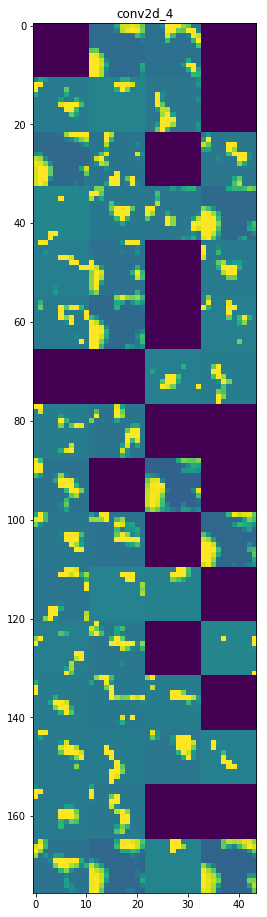

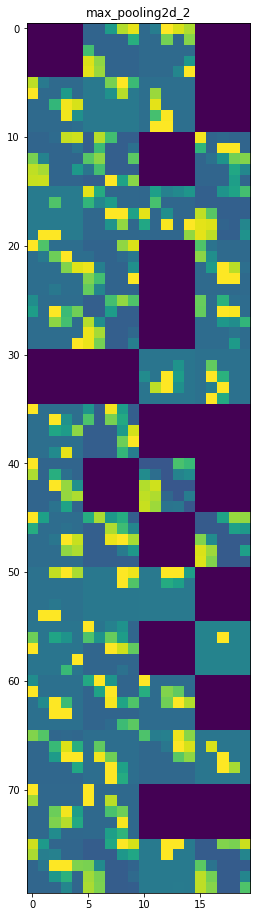

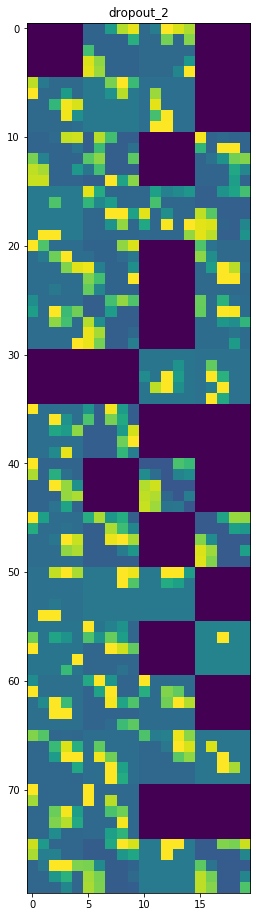

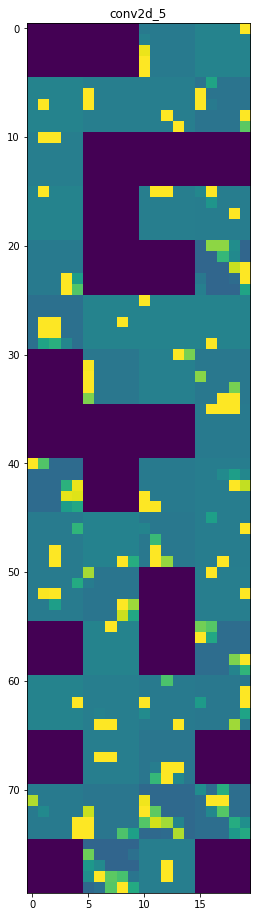

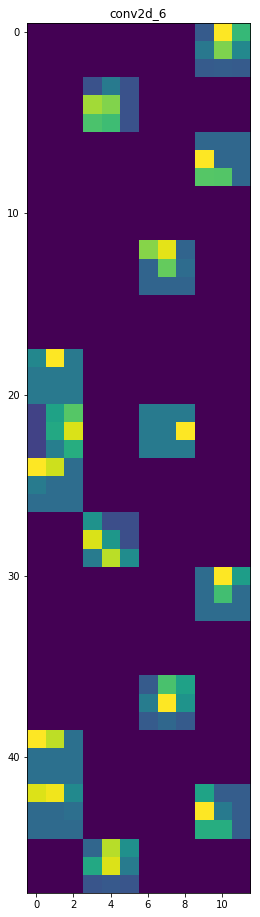

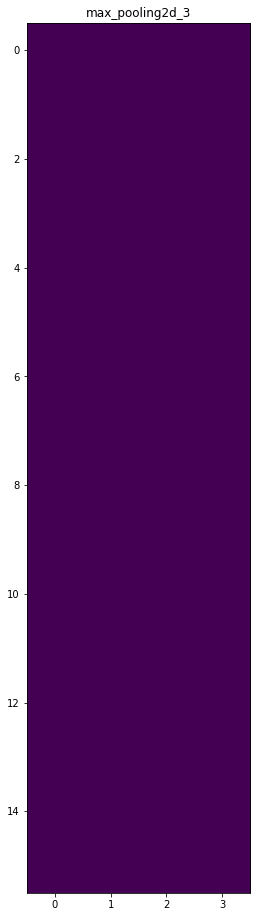

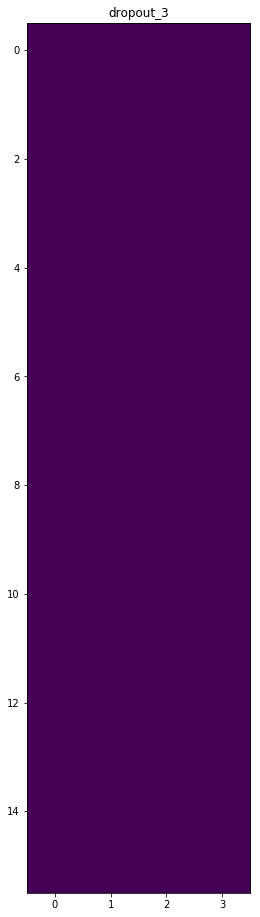

In [23]:
layer_names = []
for layer in model_cnn.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 4

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [24]:
y_pred_cnn = model_cnn.predict_classes(X_test_cnn, verbose=0)

In [25]:
from sklearn.metrics import accuracy_score
acc_cnn = accuracy_score(y_test, y_pred_cnn)
print ('CNN accuracy: ',acc_cnn)

CNN accuracy:  0.9275333333333333


## The misclassified drawings

In [26]:
flamingo_not_fish = X_test[(y_test<0.1)&(y_pred_cnn>0.9)&(y_pred_cnn<1.1)] # true: 1 (flamingo), predicted: 0 (fish)
fish_not_flamingo = X_test[(y_test<1.1)&(y_test>0.9)&(y_pred_cnn<0.1)] # true: 0 (flamingo), predicted: 1 (fish)

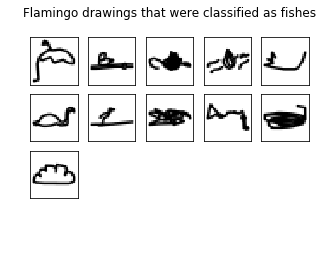

In [27]:
plot_samples(flamingo_not_fish, title = 'Flamingo drawings that were classified as fishes\n')

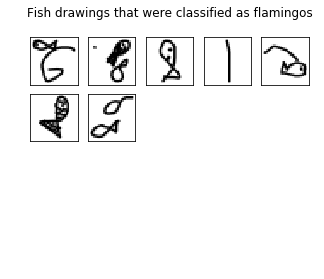

In [28]:
plot_samples(fish_not_flamingo, title = 'Fish drawings that were classified as flamingos\n')

In [29]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 5)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## The confusion matrix

Confusion matrix, without normalization
[[2332   11   97    4    5   53]
 [   7 2269  116   25    4   83]
 [  80   35 2275   21   15   65]
 [   6    7  104 2348   12   27]
 [  13   20   79   16 2395    6]
 [  27   28  111    6    4 2294]]


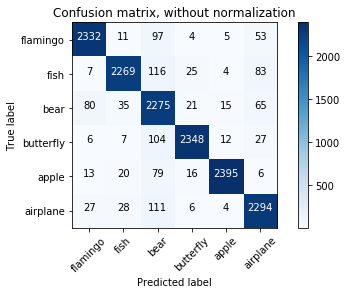

In [30]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_cnn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['flamingo','fish','bear','butterfly','apple','airplane'],
                      title='Confusion matrix, without normalization')

plt.show()

## A few examples

In [31]:
cnn_probab = model_cnn.predict(X_test_cnn, batch_size=32, verbose=0)

c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


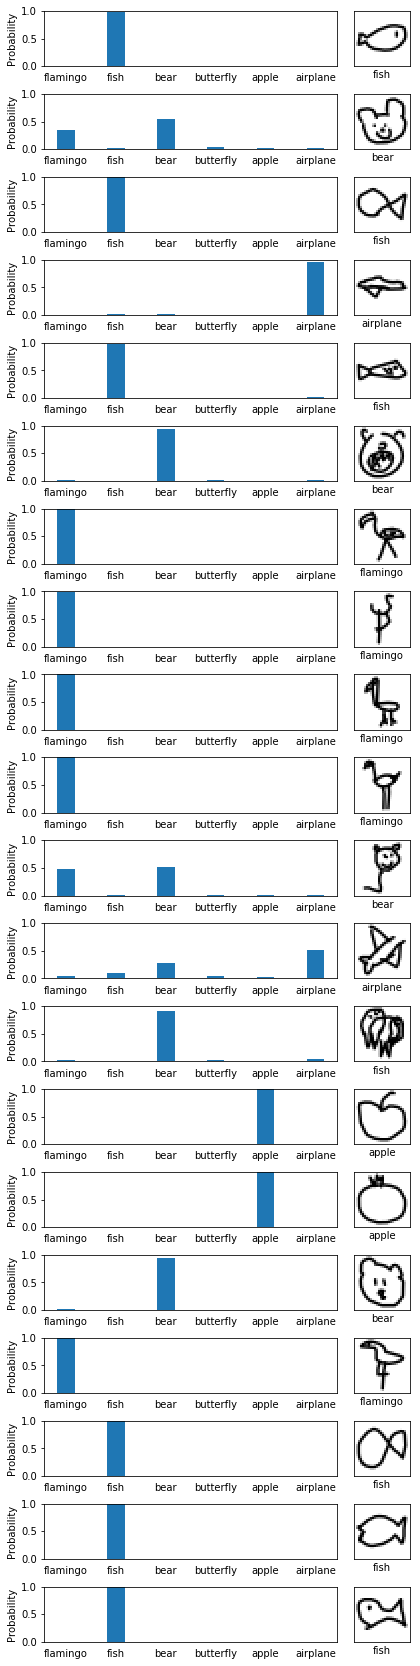

In [32]:
fig, ax = plt.subplots(figsize=(8,30))

for i in list(range(20)):

    # plot probabilities:
    ax = plt.subplot2grid((20, 6), (i, 0), colspan=4);
    plt.bar(np.arange(6), cnn_probab[i], 0.35, align='center');
    plt.xticks(np.arange(6), ['flamingo','fish','bear','butterfly','apple','airplane'])
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace = 0.5)

    # plot picture:
    ax = plt.subplot2grid((20, 6), (i, 4));
    plt.imshow(X_test[i].reshape((28,28)),cmap='gray_r', interpolation='nearest');
    plt.xlabel(label_dict[y_test[i]]); # get the label from the dict
    plt.xticks([])
    plt.yticks([])